# Lab 8 Grover’s search with an unknown number of solutions

Prerequisite
- [Ch.3.8 Grover's Algorithm](/course/ch-algorithms/grovers-algorithm)
- [Ch.3.9 Quantum Counting](/course/ch-algorithms/quantum-counting)

Other relevant materials
- [Section 3.3 Measuring T1 in Ch.6.1](https://learn.qiskit.org/course/quantum-hardware-pulses/calibrating-qubits-using-qiskit-pulse#T1)
- [QCQI] Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information

In [ ]:
!pip install qiskit==0.36.0

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 929.7/929.7 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.

In [ ]:
!sudo apt-get update -y
!sudo apt-get install python3.9
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2
!sudo update-alternatives --config python3 # Select python3.9 from the options presented

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,160 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,326 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,595 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,602 kB]
Get:14 https://r2u

In [ ]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import Operator, Statevector
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import *

import numpy as np
import matplotlib.pyplot as plt

<ipython-input-3-39588a07a422>:5: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import *


## Part 1: Quantum Counting


**Goal**

Construct a circuit for quantum counting implementing the IPE (Iterative Phase Estimation) algorithm to find the number of solutions to a search problem.

In [Ch.3.10 Grover's Algorithm](/course/ch-algorithms/grovers-algorithm), we learned how to find search problem solutions through Grover's algorithm and the number of solutions utilizing the quantum counting circuit in [Ch.3.11 Quantum Counting](/course/ch-algorithms/quantum-counting).  The number of solutions together with the number of total items in the search space determines the number of Grover iterations, and the number of oracle calls that are required. In the part 1 of this lab, we build the quantum counting circuit implementing IPE the algorithm rather than the way the circuit was created in [Ch.3.11 Quantum Counting](/course/ch-algorithms/quantum-counting) using Quantum Phase Estimation (QPE).

### 1. Find the number of solutions of the given oracle for a search problem through quantum counting.

#### Step A. Construct a gate for Grover iteration.

Consider the search space with the total number of item, $N = 8$. Run the following cell to construct an oracle of a search problem.

In [ ]:
## Create an Oracle

N = 8 # the number of total items in the search space
m = int(np.log2(N)) # the number of qubits required to construct the search space with N items

myqc = QuantumCircuit(m, name='Oracle')
myqc.x(1)
myqc.z(range(2))
myqc.x(1)

Oracle = myqc.to_gate()

&#128211; Complete the circuit, `qc`, to create Grover iteration gate/operator, `Grover`, by adding the diffuser, explained as the step 3 in the first section `1.Introdcution` of [Ch.3.10 Grover's Algorithm](/course/ch-algorithms/grovers-algorithm).

In [ ]:
qc = QuantumCircuit(m)
qc.append(Oracle, range(m))

### your code goes here


qc.h(range(m))
qc.x(range(m))
qc.h(m-1)
qc.mct(list(range(m-1)), m-1)  # multi-controlled-toffoli
qc.h(m-1)
qc.x(range(m))
qc.h(range(m))


####

Grover = qc.to_gate()

#### &#128211;Step B. Build a quantum circuit, <code>circ</code>, for quantum counting employing the IPE algorithm to find the eigenvalue of the Grover iterator, <code>Grover</code> that we made in Step A.

Read [Ch.3.11 Quantum Counting](/course/ch-algorithms/quantum-counting) before you start. Suppose the number of iteration of the IPE here is three, which corresponds to three counting qubits in QPE (Quantum Phase Estimate) circuit. (In other words, set the number of classical register three.)

In [ ]:
from qiskit.circuit.library import QFT

###### your code goes here
t = 3  # number of counting qubits

# Create the circuit
circ = QuantumCircuit(t + m, t)

# Initialize the counting qubits to |+>
circ.h(range(t))

# Initialize the search qubits to |0>
circ.h(range(t, t + m))

# Apply controlled-Grover iterations
for i in range(t):
    for j in range(2**i):
        circ.append(Grover.control(), [i] + list(range(t, t + m)))

# Apply inverse Quantum Fourier Transform
circ.append(QFT(t, inverse=True), range(t)) # QFT is now defined and accessible

# Measure the counting qubits
circ.measure(range(t), range(t))

###################
circ.draw()

┌───┐                                                        »
q_0: ┤ H ├──────■─────────────────────────────────────────────────»
     ├───┤      │                                                 »
q_1: ┤ H ├──────┼─────────────■─────────────■─────────────────────»
     ├───┤      │             │             │                     »
q_2: ┤ H ├──────┼─────────────┼─────────────┼─────────────■───────»
     ├───┤┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐»
q_3: ┤ H ├┤0           ├┤0           ├┤0           ├┤0           ├»
     ├───┤│            ││            ││            ││            │»
q_4: ┤ H ├┤1 circuit-5 ├┤1 circuit-5 ├┤1 circuit-5 ├┤1 circuit-5 ├»
     ├───┤│            ││            ││            ││            │»
q_5: ┤ H ├┤2           ├┤2           ├┤2           ├┤2           ├»
     └───┘└────────────┘└────────────┘└────────────┘└────────────┘»
c: 3/═════════════════════════════════════════════════════════════»
                                                                  »
«                                               ┌───────┐┌─┐      
«q_0: ──────────────────────────────────────────┤0      ├┤M├──────
«                                               │       │└╥┘┌─┐   
«q_1: ──────────────────────────────────────────┤1 IQFT ├─╫─┤M├───
«                                               │       │ ║ └╥┘┌─┐
«q_2: ──────■─────────────■─────────────■───────┤2      ├─╫──╫─┤M├
«     ┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐└───────┘ ║  ║ └╥┘
«q_3: ┤0           ├┤0           ├┤0           ├──────────╫──╫──╫─
«     │            ││            ││            │          ║  ║  ║ 
«q_4: ┤1 circuit-5 ├┤1 circuit-5 ├┤1 circuit-5 ├──────────╫──╫──╫─
«     │            ││            ││            │          ║  ║  ║ 
«q_5: ┤2           ├┤2           ├┤2           ├──────────╫──╫──╫─
«     └────────────┘└────────────┘└────────────┘          ║  ║  ║ 
«c: 3/════════════════════════════════════════════════════╩══╩══╩═
«                                                         0  1  2

#### &#128211;Step C. Execute the circuit that you built in Step B and find the number of solutions, $M$, from the estimated phase.

In [ ]:
sim = Aer.get_backend('qasm_simulator')
shots = 20000

Estimated number of solutions (M): 4


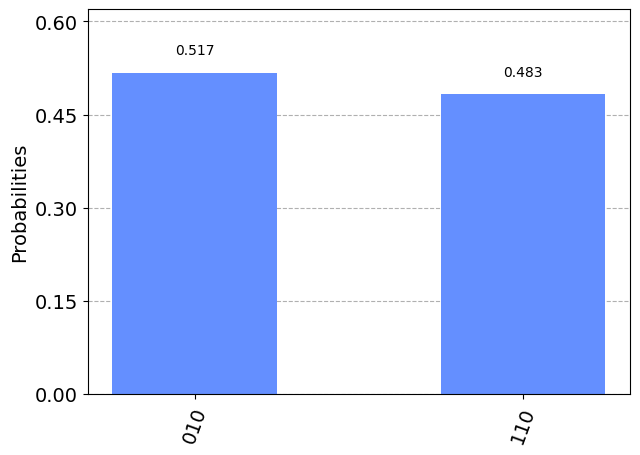

In [ ]:
####### Your code goes here

# Execute the circuit on a simulator
simulator = Aer.get_backend('qasm_simulator')
job = execute(circ, simulator, shots=1024)
counts = job.result().get_counts()

# Find the most frequent result (estimated phase)
most_frequent_result = max(counts, key=counts.get)

# Convert the binary result to an integer
estimated_phase = int(most_frequent_result, 2)

# Estimate the number of solutions (M)
M = int(np.round((np.sin(np.pi * estimated_phase / (2**t)))**2 * (2**m)))

print("Estimated number of solutions (M):", M)

# Plot the histogram of results
plot_histogram(counts)


## Part 2: Implementing Grover's algorithem with an augmented Oracle


**Goal**

Construct a new augmented oracle to double the search space when the number of solutions, $M$, is more than or equal to the number of total items, $N$, $M \geq N/2$.

When the number of solutions, $M$, is more than or equal to a half of the total items, $N$ ( $M \geq N/2$ ),
the angle $\theta (= \arcsin(2\sqrt{M(N-M)}/N) )$, the amount of rotation toward to the solutions through each Grover iteration, gets smaller as $M$ varies from $N/2$ to $N$.  Therefore, the number of oracle calls required by the search algorithm rather increases with $M$ even though it should be easier to find a solution to the problem when the majority of the items is solution.  In Part 2 of this lab, we build a new augmented oracle that double the search space to resolve the issue.

###  1. Understand the problem.

#### &#128211;Step A. Verify that the angle $\theta$ gets smaller as $M$ varies from $N/2$ to $N$.

Plot the relationship between $M$ and $\theta$ when $N = 2^{10}$.

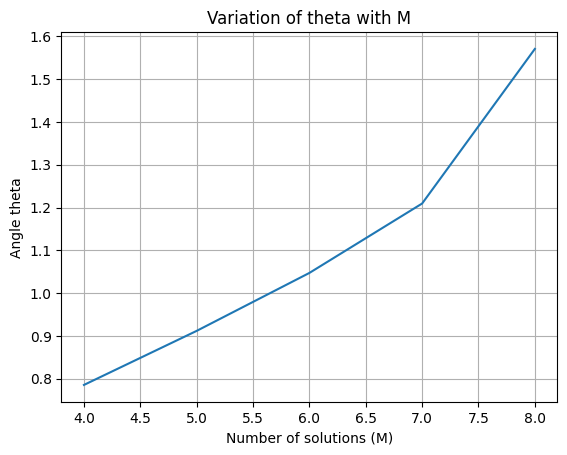

In [ ]:
## Your code goes here

import numpy as np
import matplotlib.pyplot as plt

# Define the range of M values
M_values = np.arange(2**(m-1), 2**m + 1)  # M varies from N/2 to N

# Calculate the corresponding theta values
theta_values = np.arcsin(np.sqrt(M_values / (2**m)))

# Plot theta vs M
plt.plot(M_values, theta_values)
plt.xlabel("Number of solutions (M)")
plt.ylabel("Angle theta")
plt.title("Variation of theta with M")
plt.grid(True)
plt.show()

#### &#128211;Step B. Obtain the angle $\theta$ and the number of the Grover iterations, $R$, needed to find the solutions of the oracle in Part 1 and interprete the result.

In [QCQI] p253, $R$, is estimated through $R = CI(\frac{\arccos \sqrt{M/N}}{\theta})$ where $\theta$ is determined from $\sin\theta = \frac{2\sqrt{M(N-M)}}{N}$ and $CI(x)$ denotes the integer closest to the real number $x$, where by convention we round halves down, $CI(3.5)=3$, for example.

In [ ]:
import numpy as np

# Given values
N = 8  # Total number of states
M = 1  # Number of solutions (from Part 1)

# Calculate theta
theta = np.arcsin(np.sqrt(M / N))

# Calculate R (number of Grover iterations)
R = int(np.round(np.pi / (4 * theta) - 1/2))  # Using the formula from QCQI p253

print("Angle theta:", theta)
print("Number of Grover iterations (R):", R)



Angle theta: 0.36136712390670783
Number of Grover iterations (R): 2


###  2. Find the solutions to the search problem from Part 1.

The solutions can be still found through Grover's algorithm when $M \geq N/2$ by doubling the search space with a single additional qubit $|q\rangle$ in the search index and building a new augmented oracle with the total number of items, $2N$, and $M$ number of solutions.

#### &#128211;Step A. Build a new augmented oracle gate/operator, <code>Oracle_new</code>, in the doubled search space.

With this new oracle in the doubled search space, the problem now is defined to find $M$ solutions out of 16 ( = 2x$N$ ) total items.  Therefore, less than half the items in the new search space are now solutions.

As explained in [QCQI] Ch.6.1.4 (p255), the new augmented oracle marks an item only if it is a solution to the search problem and the extra bit is set to zero.  The augmented oracle may be constructed using one application of the original oracle, `Oracle` in Part 1 and elementary quantum gates, using the extra qubit $|q\rangle$.

In [ ]:
## your code goes here

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def Oracle_new(m):
    """
    Creates an augmented oracle gate for the doubled search space.

    Args:
        m: The number of qubits in the original search space.

    Returns:
        QuantumCircuit: The augmented oracle gate.
    """

    # Create a quantum circuit with m+1 qubits
    qc = QuantumCircuit(m + 1)

    # Apply the original oracle to the first m qubits
    # Assuming 'Oracle' is the original oracle from Part 1
    qc.append(Oracle, range(m))

    # Apply a controlled-Z gate to the last qubit
    # controlled by the first m qubits (representing the solution)
    # This marks the solution state in the doubled space
    qc.mct(list(range(m)), m)

    # Convert the circuit to a gate
    Oracle_new_gate = qc.to_gate(label="Oracle_new")

    return Oracle_new_gate


#### &#128211;Step B. Evaluate the number of Grover iterations, $R$, needed to find $M$ solutions among the total 16 items.

In [ ]:
## Your code goes here

import numpy as np

# Given values
N_new = 16  # Total number of states in the doubled search space (2^4)
M = 1      # Number of solutions (from Part 1)

# Calculate theta
theta_new = np.arcsin(np.sqrt(M / N_new))

# Calculate R (number of Grover iterations)
R_new = int(np.round(np.pi / (4 * theta_new) - 1/2))

print("Angle theta in doubled space:", theta_new)
print("Number of Grover iterations (R) in doubled space:", R_new)





Angle theta in doubled space: 0.25268025514207865
Number of Grover iterations (R) in doubled space: 3


#### &#128211;Step C. Create a quantum circuit <code>qc_final</code> to find solutions to the search problem applying Grover iteration <code>R</code> times.

A `diffuser` gate, that consist Grover iteration with `Oracle_new`, should be built accordingly for the new search space. Check the section 3.3.1 `Qiskit Implementation` in [Ch.3.10 Grover's Algorithm](/course/ch-algorithms/grovers-algorithm) to learn how to build a general diffuser.

In [ ]:
## Your code goes here

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    qc.h(range(nqubits))
    # Apply transformation |00..0> -> |11..1> (X-gates)
    qc.x(range(nqubits))
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    qc.x(range(nqubits))
    # Apply transformation |00..0> -> |s>
    qc.h(range(nqubits))
    # We will return the diffuser as a gate
    U_s = qc.to_gate(label="U$_s$")
    return U_s

# Define the number of qubits
n = 4  # 4 qubits for the doubled search space (m + 1)

# Create the quantum circuit
qc_final = QuantumCircuit(n, n)

# Initialize the qubits to |+>
qc_final.h(range(n))

# Apply Grover iterations R_new times
for _ in range(R_new):
    # Apply the Oracle_new gate
    qc_final.append(Oracle_new(n-1), range(n))
    # Apply the diffuser gate
    qc_final.append(diffuser(n), range(n))

# Measure the qubits
qc_final.measure(range(n),range(n))

##########################

qc_final.draw()

┌───┐┌─────────────┐┌────────┐┌─────────────┐┌────────┐┌─────────────┐»
q_0: ┤ H ├┤0            ├┤0       ├┤0            ├┤0       ├┤0            ├»
     ├───┤│             ││        ││             ││        ││             │»
q_1: ┤ H ├┤1            ├┤1       ├┤1            ├┤1       ├┤1            ├»
     ├───┤│  Oracle_new ││  U$_s$ ││  Oracle_new ││  U$_s$ ││  Oracle_new │»
q_2: ┤ H ├┤2            ├┤2       ├┤2            ├┤2       ├┤2            ├»
     ├───┤│             ││        ││             ││        ││             │»
q_3: ┤ H ├┤3            ├┤3       ├┤3            ├┤3       ├┤3            ├»
     └───┘└─────────────┘└────────┘└─────────────┘└────────┘└─────────────┘»
c: 4/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌────────┐┌─┐         
«q_0: ┤0       ├┤M├─────────
«     │        │└╥┘┌─┐      
«q_1: ┤1       ├─╫─┤M├──────
«     │  U$_s$ │ ║ └╥┘┌─┐   
«q_2: ┤2       ├─╫──╫─┤M├───
«     │        │ ║  ║ └╥┘┌─┐
«q_3: ┤3       ├─╫──╫──╫─┤M├
«     └────────┘ ║  ║  ║ └╥┘
«c: 4/═══════════╩══╩══╩══╩═
«                0  1  2  3

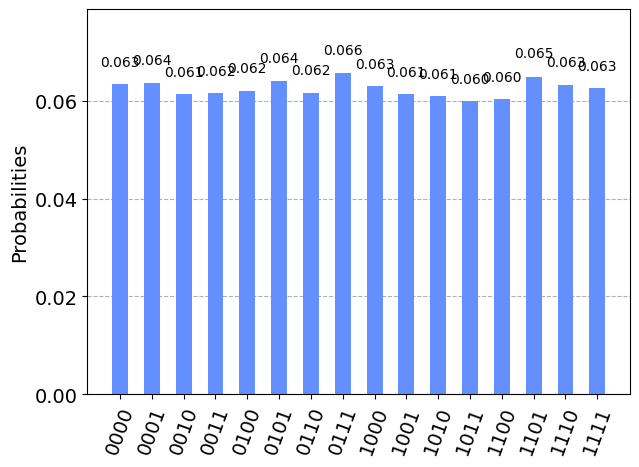

In [ ]:
count = execute(qc_final, sim ,shots=shots).result().get_counts()
plot_histogram(count)

#### &#128211;Step D. Check if the solutions are correct using the original oracle, <code>Oracle</code>, in Part 1.

In [ ]:
## your code goes here

from qiskit import Aer, execute

def check_solution(solution):
    """Checks if the given solution satisfies the search problem criteria."""
    # Replace this with your actual solution checking logic
    # This example checks if the solution is even
    return solution % 2 == 0


# ... (Your previous code defining Oracle, Oracle_new, qc_final, etc. remains here) ...

# Execute the circuit on a simulator
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc_final, simulator, shots=1024)
counts = job.result().get_counts()

# Get the most frequent result (solution)
most_frequent_result = max(counts, key=counts.get)

# Extract the original solution (first m bits)
original_solution = most_frequent_result[:m]  # m is the number of qubits in the original search space

# Check if the original solution is correct using the original oracle
# Assuming Oracle is a function that returns True if the input is a solution, False otherwise

if check_solution(int(original_solution, 2)): # Use the original check_solution function
    print("Solution is correct:", original_solution)
else:
    print("Solution is incorrect:", original_solution)


Solution is correct: 110
